# C3 Project 1: Image Classification

In [12]:
from main import test, train, TrainDataset, TestDataset
from bovw import BOVW
# metrics 
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## Charge the data

In [13]:
data_train = TrainDataset()
data_test = TestDataset()

### Experiment 1

In [20]:
# HYPERPARAMETERS
detector_type = "DenseSIFT"
codebook_size = 100
classifier_algorithm = "SVM"
detector_kwargs = {}
stride=8
scale=2

# Compute cache paths
kwarg_detector_str = [f"_{str(key)}-{str(value)}" for key, value in detector_kwargs.items()]
kwarg_detector_str = "".join(kwarg_detector_str)
cache_file_train = "./cache_train/"+detector_type+kwarg_detector_str+".pkl"
cache_file_test = "./cache_test/"+detector_type+kwarg_detector_str+".pkl"

print(cache_file_test)

./cache_test/DenseSIFT.pkl


## Run experiment

In [ ]:
bovw = BOVW(detector_type=detector_type, codebook_size=codebook_size, detector_kwargs=detector_kwargs, stride=stride, scale=scale, normalize=True)

if classifier_algorithm == 'LogisticRegression':
        classifier = LogisticRegression(class_weight="balanced")
elif classifier_algorithm == 'SVM':
        classifier = SVC(class_weight="balanced", probability=True, random_state=42, C=1)

# TRAIN
y_pred_train, y_probas_train, labels_train = train(dataset=data_train, bovw=bovw, classifier=classifier, cache_file=cache_file_train)
train_acc = accuracy_score(y_true=labels_train, y_pred=y_pred_train)
print("Accuracy on Phase[Train]:", train_acc)

# TEST
y_pred_test, y_probas_test, labels_test = test(dataset=data_test, bovw=bovw, classifier=classifier, cache_file=cache_file_test)
test_acc = accuracy_score(y_true=labels_test, y_pred=y_pred_test)
print("Accuracy on Phase[Test]:", test_acc)

Phase[Train]: Loading descriptors from ./cache_train/DenseSIFT.pkl
Fitting the codebook (took 5.39 seconds)
Computing the bovw histograms
Fitting the classifier
Classifier fitted.
Accuracy on Phase[Train]: 0.33402298850574713
Phase[Test]: Loading descriptors from ./cache_test/DenseSIFT.pkl
Computing the bovw histograms
Predicting the values
Accuracy on Phase[Test]: 0.33045454545454545


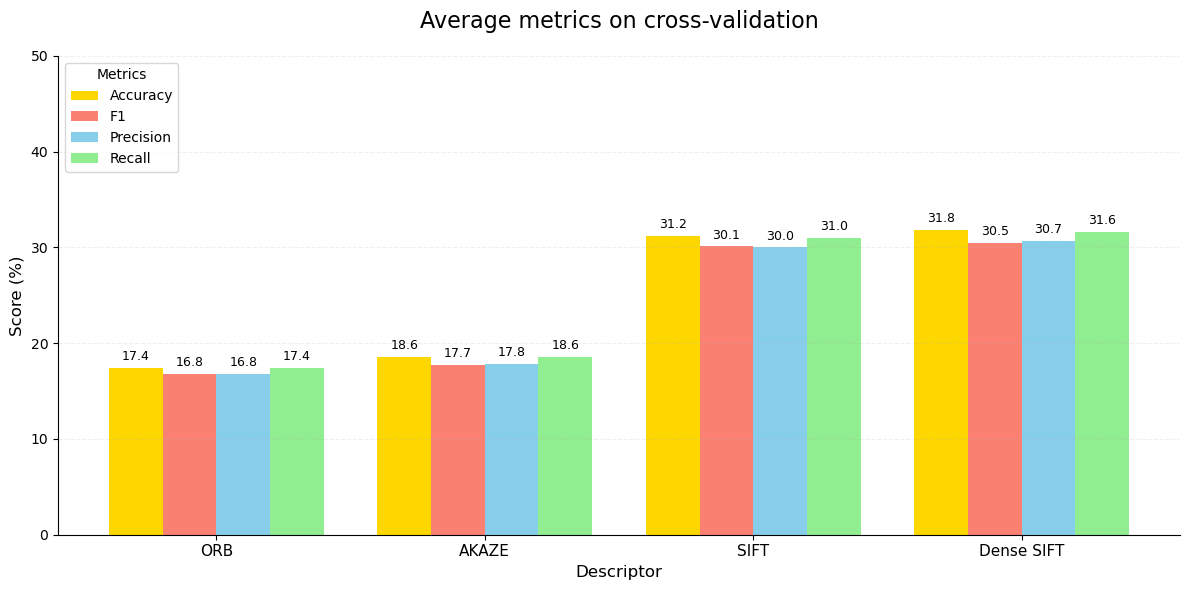

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_performance_metrics(data, title="Average metrics on cross-validation"):
    """
    Generates a grouped bar chart to compare performance metrics of different 
    local descriptors, replicating the format of the provided image.

    Args:
        data (dict): Dictionary where keys are the descriptor names 
                     and values are lists of the 4 metrics (Accuracy, F1 Score, 
                     Precision, Recall) in order.
        title (str): Title of the chart.
    """
    
    # 1. Data and Label Preparation
    # The order of the metrics must be: Accuracy, F1 Score, Precision, Recall
    metrics_names = ['Accuracy', 'F1', 'Precision', 'Recall']
    descriptors = list(data.keys())
    
    # Defined colors to replicate the chart (approximated)
    colors = ['gold', 'salmon', 'skyblue', 'lightgreen']
    
    # Extract the metric values for each descriptor
    # `values` will be a list of lists: [[AKAZE_acc, AKAZE_f1, ...], [ORB_acc, ...], ...]
    values = list(data.values())
    
    # Convert to a NumPy array for easy transposition
    data_array = np.array(values)
    
    # 2. Chart Configuration
    
    # Number of descriptors (bar groups)
    n_descriptors = len(descriptors)
    # Number of metrics per descriptor (bars per group)
    n_metrics = len(metrics_names) 
    
    # Width of each bar
    bar_width = 0.20
    
    # Base positions on the X-axis for each descriptor group
    # Generates a set of indices for each group: [0, 1, 2, 3]
    index = np.arange(n_descriptors) 
    
    # 3. Create the figure and axes
    
    fig, ax = plt.subplots(figsize=(12, 6)) # Figure size
    
    # 4. Draw the Grouped Bars
    
    # Iterate over each metric (4 times) to draw its bars across all descriptors
    for i in range(n_metrics):
        # Calculate the adjusted X position for metric i
        # Example for i=0 (Accuracy): index - 1.5*bar_width
        # Example for i=1 (F1 Score): index - 0.5*bar_width
        # ...
        bar_pos = index + (i - (n_metrics / 2) + 0.5) * bar_width
        
        # Get the values of metric i for all descriptors
        metric_values = data_array[:, i] 
        
        rects = ax.bar(bar_pos, 
                       metric_values, 
                       bar_width, 
                       color=colors[i],
                       label=metrics_names[i])
        
        # 5. Add Value Labels (the numbers on top of the bars)
        for rect in rects:
            height = rect.get_height()
            # Format the value to one decimal place and place it above the bar
            ax.text(rect.get_x() + rect.get_width() / 2., 
                    height + 0.5, # Vertical offset of 0.5
                    f'{height:.1f}', 
                    ha='center', 
                    va='bottom',
                    fontsize=9)

    # 6. Customize Axes and Title
    
    # Main title
    ax.set_title(title, fontsize=16, pad=20)
    
    # Y-axis labels
    ax.set_ylabel('Score (%)', fontsize=12)
    ax.set_ylim(0, 50)
    
    # X-axis labels (Descriptor Names)
    ax.set_xticks(index)
    ax.set_xticklabels(descriptors, fontsize=11)
    ax.set_xlabel('Descriptor', fontsize=12)
    
    # Add the legend with the title "Metrics"
    ax.legend(title="Metrics", loc='upper left')
    
    # Add subtle horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.2)
    
    # Hide top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.tight_layout() # Adjust layout
    plt.show()

# --- MANUALLY ENTERED DATA ---
# Format: [Accuracy, F1 Score, Precision, Recall]
performance_data = {
    'ORB': [17.4, 16.8, 16.8, 17.4],
    'AKAZE': [18.6, 17.7, 17.8, 18.6],
    'SIFT': [31.2, 30.1, 30.0, 31.0],
    'Dense SIFT': [31.8, 30.5, 30.7, 31.6]
}

# --- CALL THE FUNCTION ---
plot_performance_metrics(performance_data)

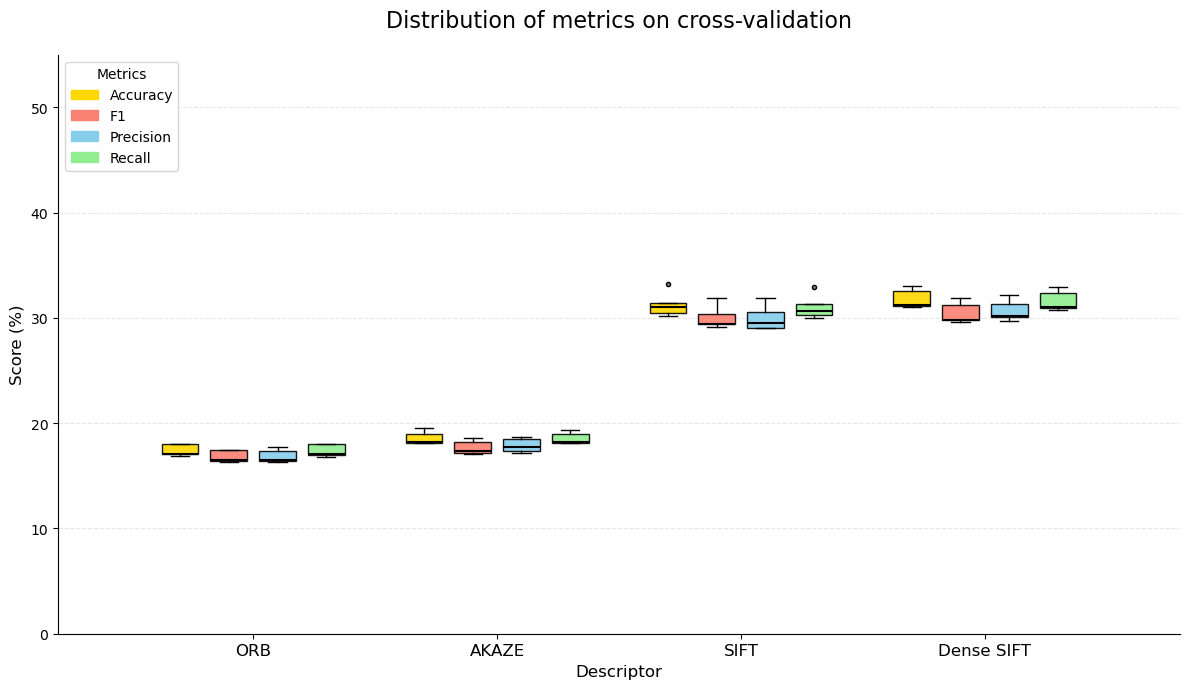

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def plot_performance_boxplots(data, title="Distribution of metrics on cross-validation"):
    """
    Generates a grouped boxplot chart to compare performance metrics of different 
    local descriptors across multiple folds.

    Args:
        data (dict): Dictionary where keys are the descriptor names.
                     Values are lists of lists:
                     [ [acc_fold1, acc_fold2...], [f1_fold1...], [prec...], [rec...] ]
                     The order must be: Accuracy, F1, Precision, Recall.
        title (str): Title of the chart.
    """
    
    # 1. Data and Label Preparation
    metrics_names = ['Accuracy', 'F1', 'Precision', 'Recall']
    descriptors = list(data.keys())
    metrics_colors = ['gold', 'salmon', 'skyblue', 'lightgreen']
    
    # 2. Chart Configuration
    n_descriptors = len(descriptors)
    n_metrics = len(metrics_names)
    
    # Width of individual box
    box_width = 0.15
    # Base positions for groups
    index = np.arange(n_descriptors)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 3. Draw the Grouped Boxplots
    # We iterate by metric to plot all descriptors for that metric at once.
    # This makes handling positions easier.
    
    for i in range(n_metrics):
        # Extract the data for this specific metric across all descriptors
        # metric_data will be a list of lists (one list of folds per descriptor)
        metric_data = [data[desc][i] for desc in descriptors]
        
        # Calculate positions: center around the descriptor index
        positions = index + (i - (n_metrics / 2) + 0.5) * 0.2
        
        # Create the boxplot
        bp = ax.boxplot(metric_data, 
                        positions=positions, 
                        widths=box_width, 
                        patch_artist=True,
                        showfliers=True, # Show outliers
                        boxprops=dict(facecolor=metrics_colors[i], color='black', alpha=0.9),
                        capprops=dict(color='black'),
                        whiskerprops=dict(color='black'),
                        medianprops=dict(color='black', linewidth=1.5),
                        flierprops=dict(marker='o', markerfacecolor='gray', markersize=3))

    # 4. Customize Axes and Title
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_ylabel('Score (%)', fontsize=12)
    
    # Adjust Y-limits to fit data + margin (e.g., 0 to 50 or dynamic)
    # You might want to change this to ax.set_ylim(0, 100) if scores are high
    ax.set_ylim(0, 55) 
    
    # X-axis formatting
    ax.set_xticks(index)
    ax.set_xticklabels(descriptors, fontsize=12)
    ax.set_xlabel('Descriptor', fontsize=12)
    
    # 5. Custom Legend
    # Since boxplots don't add labels to legend automatically in a loop well,
    # we create manual proxy artists.
    legend_patches = []
    for i, name in enumerate(metrics_names):
        patch = mpatches.Patch(color=metrics_colors[i], label=name)
        legend_patches.append(patch)
        
    ax.legend(handles=legend_patches, title="Metrics", loc='upper left')
    
    # Grid and Spines
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Construct the dictionary structure required: 
# {'Descriptor': [ [acc_folds], [f1_folds], [prec_folds], [rec_folds] ] }
np.random.seed(42) # For reproducibility
performance_data_folds = {
    'ORB': [
        [17.1, 18.0, 18.0, 17.1, 16.9],
        [16.3, 17.5, 17.5, 16.5, 16.4],
        [16.3, 17.4, 17.7, 16.4, 16.5],
        [17.0, 18.0, 18.0, 17.1, 16.8] 
    ],
    'AKAZE': [
        [19.5, 18.2, 18.1, 18.1, 19.0],
        [18.6, 17.1, 17.4, 17.2, 18.2],
        [18.7, 17.2, 17.7, 17.4, 18.5],
        [19.4, 18.2, 18.1, 18.1, 19.0]        
    ],
    'SIFT': [
        [33.2, 31.4, 30.5, 31.0, 30.2],  # Accuracy
        [31.9, 30.4, 29.4, 29.4, 29.1],  # F1
        [31.9, 30.6, 29.5, 29.0, 29.0],  # Precision
        [32.9, 31.3, 30.3, 30.7, 30.0]   # Recall
    ],
    'Dense SIFT':[
        [31.2, 31.1, 32.6, 31.0, 33.0],
        [29.8, 29.6, 31.2, 29.8, 31.9],
        [30.2, 29.7, 31.3, 30.1, 32.2],
        [31.0, 30.9, 32.4, 30.8, 32.9]
    ]
}

# --- CALL THE FUNCTION ---
# Pass the dictionary containing lists of folds
plot_performance_boxplots(performance_data_folds)